##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024

## TP2: Plongements de mots

## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

### Objectif du TP

L'objectif de ce TP est d'entraîner un modèle de plongements lexicaux qui intègre des notions de synonymie et d'antonymie en utilisant des réseaux de neurones.

Contrairement aux plongements vus en cours comme GloVe ou Word2Vec, qui positionnent souvent les mots à proximité équivalente de leurs synonymes et antonymes, nous chercherons à faire distinguer à nos modèles les synonymes et antonymes, en rapprochant les mots de leurs synonymes et en les éloignant de leurs antonymes.

### Jeux de données

**Paires de synonymes et antonymes** (entraînement) : Les fichiers `train_synonyms.txt` et `train_antonymms.txt` contiennent les paires de synonymes et d'antonymes qui serviront à l'entraînement de nos modèles.
- train_synonyms: ~640k paires de synonymes
- train_antonyms: ~12k paires d'antonymes

**SimLex-999** (test) : Le fichier `simlex_english.txt` contient 1000 paires de mots et leur similarité entre 0 et 10. Des antonymes auront une similarité de 0 et des mots proches auront une similarité plus élevée. Par exemples :

- *nice* & *cruel* -> 0
- *violent* & *angry* -> 5.9
- *essential* & *necessary* -> 9.8

### Développement du TP

Le TP suivra les étapes suivantes:

- Partie 1 : Familiarisation avec GloVe, modèle de plongements de mots pré-entraîné
- Partie 2 : Évaluation de GloVe sur SimLex-999
- Partie 3 : Mise en place de la méthode d'entraînement
- Partie 4 : Entraînement de zéro (baseline)
- Partie 5 : Entraînement utilisant GloVe pré-entraîné et conclusion

Le TP est noté sur 89 points.

### Librairies autorisées

+ numpy
+ pandas
+ torch
+ matplotlib

Si vous voulez utiliser une autre librairie, veuillez demander à votre chargé de lab.

### Imports

Les imports effectués dans la cellule suivante devraient être suffisants pour faire tout ce TP.

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install torch
#!pip install matplotlib
#!pip install torch torchvision torchaudio



In [6]:
from tqdm import tqdm
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

### 1. GloVe (10 Points)

Dans ce TP, nous allons utiliser le modèle pré-entraîné GloVe qui crée des plongements lexicaux de mots.

#### 1.1 Chargement du modèle

La cellule suivante permet charger le modèle GloVe pré-entraîné. Le chargement du modèle peut prendre quelques minutes.

In [2]:
# Décommenter pour télécharger les GloVe embeddings à partir de https://nlp.stanford.edu/projects/glove/
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip -P /content
!unzip /content/glove.42B.300d.zip -d /content

--2024-10-10 14:10:50--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2024-10-10 14:10:50--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2024-10-10 14:10:51--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]


In [7]:

data_root = '/content'

pretrained_model_path = f"{data_root}/glove.42B.300d.txt"
train_synonyms_path = f"{data_root}/train_synonyms.txt"
train_antonyms_path = f"{data_root}/train_antonyms.txt"

eval_simlex = f'{data_root}/simlex_english.txt'

In [8]:
def load_word_vectors(filepath, vocab=None):
    """
    Télécharge le modèle pré-entraîné de plongements de mots en pytorch
    """
    word_to_index = {}
    embeddings = []
    index = 0

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            if vocab is None or word in vocab:
                embedding = np.array(split_line[1:], dtype=np.float32)
                word_to_index[word] = index
                embeddings.append(embedding)
                index += 1

    embeddings = np.stack(embeddings)
    embeddings = torch.from_numpy(embeddings)
    return word_to_index, embeddings

In [9]:
word_to_index, embeddings = load_word_vectors(pretrained_model_path)

#### 1.2 Implémentez la fonction `cosine_similarity` avec pytorch et sans utiliser `torch.nn.CosineSimilarity` (2 points)

In [10]:
def cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Calcule la matrice de similarité cosinus entre deux matrices.

    Args:
        a   : torch.Tensor, shape=(n, d)  # Matrice d'embeddings pour n vecteurs de dimension d
        b   : torch.Tensor, shape=(m, d)  # Matrice d'embeddings pour m vecteurs de dimension d

    Returns:
        torch.Tensor, shape=(n, m)  # Matrice de similarité cosinus entre a et b
    """

    # Éviter la division par zéro en ajoutant une petite valeur epsilon
    #epsilon = 1e-10

    # Calcul des normes
    a_norm = a.norm(dim=1, keepdim=True)  # Normalisation de a
    b_norm = b.norm(dim=1, keepdim=True)  # Normalisation de b

    # Normalisation des vecteurs
    a_normalized = a / a_norm  # Vecteurs normalisés de a
    b_normalized = b / b_norm  # Vecteurs normalisés de b

    # Calcul de la matrice de similarité cosinus via produit matriciel
    return torch.mm(a_normalized, b_normalized.T)  # Produit matriciel entre a_normalized et b_normalized transposé


#### 1.3 Complétez la fonction `n_closest_vect` qui retourne les n mots les plus proches d'un mot donné. (5 points)

`n_closest_vect` prendra en entrée la matrice des plongements `embeddings`, le dictionnaire de correspondance entre les mots et les indices `word_to_index`, le plongement d'un mot `word` et le nombre `n` de mots attendus. La fonction devra retourner la liste des mots dont les plongements sont les plus proches du vecteur de référence et leur similarité cosinus.

C'est-à-dire les n mots avec lesquels le mot a la plus grande similarité cosinus. Utilisez la fonction `cosine_similarity` que vous venez d'implémenter.

In [11]:
def n_closest_vect(embeddings: torch.Tensor, word_to_index: dict, word: torch.Tensor, n: int = 5) -> list:
    """
    Trouve les n mots les plus proches du vecteur donné et leur similarité.

    Args:
        embeddings      : torch.Tensor, shape=(vocab_size, embedding_dim)
                          Matrice de plongement de tous les mots.

        word_to_index   : dict
                          Dictionnaire qui relie un mot à son index dans le vocabulaire.

        word            : torch.Tensor, shape=(embedding_dim,)
                          Plongement du mot dont on cherche les n mots les plus proches.

        n               : int, optional, default=5
                          Nombre de mots à retourner.

    Returns:
        list: Liste de tuples contenant les n mots les plus similaires avec leur coefficient
              de similarité.
    """
    # Calculer les similarités entre le mot donné et tous les autres mots
    similarities = cosine_similarity(word.unsqueeze(0), embeddings)

    # Obtenir les n similarités les plus élevées et leurs indices correspondants
    top_n_similarities, top_n_indices = torch.topk(similarities.squeeze(0), n)

    # Créer une liste pour stocker les mots les plus similaires et leurs similarités
    mots_proches= []

    for i in range(n):
        # Récupérer le mot correspondant à l'indice et sa similarité
        similar_word = list(word_to_index.keys())[top_n_indices[i].item()]
        similarity_score = top_n_similarities[i].item()
        mots_proches.append((similar_word, similarity_score))

    return mots_proches


In [12]:
# Exemple
print(n_closest_vect(embeddings, word_to_index, embeddings[word_to_index['morning']]))

[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]


Sortie attendue :
```
[('morning', 1.0), ('afternoon', 0.8665473461151123), ('evening', 0.7880070209503174), ('yesterday', 0.7614548206329346), ('sunday', 0.7548925876617432)]
```

#### 1.4 Quelle est la similarité cosinus entre 'fast' et 'slow' ? Entre 'fast' et 'rapid' ? Commentez les résultats et expliquez leur origine. (3 points)

In [14]:
# TODO
similarity_fast_slow = cosine_similarity(embeddings[word_to_index['fast']].unsqueeze(0), embeddings[word_to_index['slow']].unsqueeze(0))
print("Similarité cosinus entre 'fast' et 'slow':", similarity_fast_slow.item())

similarity_fast_rapid = cosine_similarity(embeddings[word_to_index['fast']].unsqueeze(0), embeddings[word_to_index['rapid']].unsqueeze(0))
print("Similarité cosinus entre 'fast' et 'rapid':", similarity_fast_rapid.item())

analyse_a=""""
la similarité cosinus élevée entre 'Fast' et 'slow' montre que les deux mots bien que antonymes sont utilisés dans des
contextes similaires dans notre corpus.
"""

analyse_b=""""
Tandis que la similarité cosinus un peu moins élevée entre 'Fast' et 'rapid' confirme que les deux mots sont proches sur le plan sémantique mais
apparaissent moins que les deux précédents dans notre contexte.
"""

print(analyse_a)
print(analyse_b)

# END TODO

Similarité cosinus entre 'fast' et 'slow': 0.7113727331161499
Similarité cosinus entre 'fast' et 'rapid': 0.6445335149765015
"
la similarité cosinus élevée entre 'Fast' et 'slow' montre que les deux mots bien que antonymes sont utilisés dans des
contextes similaires dans notre corpus.

"
Tandis que la similarité cosinus un peu moins élevée entre 'Fast' et 'rapid' confirme que les deux mots sont proches sur le plan sémantique mais
apparaissent moins que les deux précédents dans notre contexte.



### 2. Évaluation (12 Points)

#### Données

Les cellules qui suivent permettent de télécharger les données et de se restreindre au vocabulaire qui nous sera utile, pour éviter de charger des plongements inutiles.

Comme décrit dans l'introduction, nous avons 3 fichiers de données:
- Des paires de synonymes pour l'entraînement (`train_synonyms.txt`)
- Des paires d'antonymes pour l'entraînement (`train_antonymms.txt`)
- Des paires de mots avec leur similarité pour l'évaluation (`simlex_english.txt`)

In [15]:
def load_data(filepath):
    """
    Télécharge les paires de synonymes et antonymes
    """
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            pair = line.strip().split()
            assert pair[0].startswith('en_') and pair[0].startswith('en_')
            data.append((pair[0][3:], pair[1][3:]))
    return data

def data_to_tensor(data, word_to_index):
    indices = [word_to_index[word] for pair in data for word in pair if word in word_to_index]
    return torch.tensor(indices).view(-1, 2)

In [16]:
# Données d'entraînement
train_synonyms = load_data(train_synonyms_path)
train_antonyms = load_data(train_antonyms_path)

# Données d'évaluation
evaluation_simlex = pd.read_csv(eval_simlex, sep='\t') # pd dataframe with columns 'word 1', 'word 2', 'score'

# On se restreint au vocabulaire qu'on va utiliser pour éviter de charger des embeddings inutiles
vocab = set([word for pair in train_synonyms + train_antonyms for word in pair])
eval_vocab = set(evaluation_simlex['word 1']).union(set(evaluation_simlex['word 2']))
vocab.update(eval_vocab)

glove_word_to_index, glove_embeddings = load_word_vectors(pretrained_model_path, vocab)

#### 2.1 Observation du jeu de données SimLex-999. (2 points)

Affichez l'histogramme de fréquence des scores de similarité dans le jeu de données SimLex-999. Utilisez `bins=40`. Votre axe des x doit représenter le score de similarité et votre axe des y doit représenter la fréquence. Comment interpréter un score de 0?

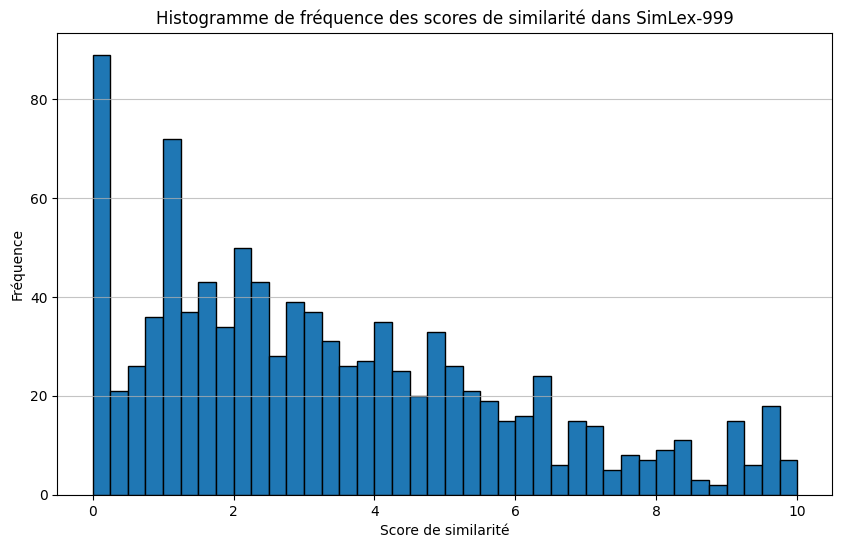

In [17]:
# TODO
# Histogramme des scores de similarité
plt.figure(figsize=(10, 6))
plt.hist(evaluation_simlex['score'], bins=40, edgecolor='black')
plt.xlabel('Score de similarité')
plt.ylabel('Fréquence')
plt.title('Histogramme de fréquence des scores de similarité dans SimLex-999')
plt.grid(axis='y', alpha=0.75)
plt.show()
# END TODO

#### 2.2 Corrélation de Spearman


La corrélation de Spearman est une mesure de la relation monotone entre deux variables $x$ et $y$. Elle est comprise entre -1 et 1. Plutôt que de comparer les valeurs brutes des variables, elle compare leurs rangs. Elle est calculée comme suit :
$$\rho (x, y) = 1 - \frac{6 \sum_{i=1}^n (r_{x_i} - r_{y_i})^2}{n(n^2 - 1)}$$
où $r_{x_i}$ est le rang de la i-ème valeur de la variable x, $r_{y_i}$ est le rang de la i-ème valeur de la variable y, $n$ est le nombre total de paires d'observations $(x, y)$.

Les rangs sont attribués en ordonnant les valeurs de chaque variable du plus petit au plus grand. La plus petite valeur reçoit le rang 1, la suivante le rang 2, et ainsi de suite.

##### Expliquez pourquoi on utilise la corrélation de Spearman plutôt que la corrélation entre les valeurs des variables. (3 points)


In [18]:
analyse_spearman=""""
La corrélation de Spearman utilise les rangs des variables plutôt que les valeurs de ces varaibles. Ceci étant, on est moins sensible aux données extrèmes.
D'autre part, les données sur lesquelles le TP est basé ne suivent pas forcément une distribution normale donc utiliser les rangs plutôt que les valeurs est également un avantage.
Enfin c'est une corrélation qui utilise les rangs donc c'est possible de travailler sur des données avec des types non communs et données ordinales.

"""

print(analyse_spearman)

"
La corrélation de Spearman utilise les rangs des variables plutôt que les valeurs de ces varaibles. Ceci étant, on est moins sensible aux données extrèmes.
D'autre part, les données sur lesquelles le TP est basé ne suivent pas forcément une distribution normale donc utiliser les rangs plutôt que les valeurs est également un avantage.
Enfin c'est une corrélation qui utilise les rangs donc c'est possible de travailler sur des données avec des types non communs et données ordinales.




#### 2.3 Implémentation de la corrélation de Spearman (2 points)

Complétez la fonction suivante pour calculer la corrélation de Spearman entre deux listes de valeurs.

In [19]:
def spearman_rank_correlation(x, y):
    """
    Calcule la corrélation de Spearman entre deux listes de valeurs.

    Args:
        x   : list of float
        y   : list of float

    Returns:
    La corrélation de Spearman entre les deux listes (float).
    """



    # TODO
       # Vérifier que les listes ont la même longueur
    if len(x) != len(y):
        raise ValueError("Les listes doivent avoir la même longueur.")

    # Conversion des listes en tableaux numpy
    x = np.array(x)
    y = np.array(y)

    # Calcul des rangs
    rank_x = np.argsort(np.argsort(x))
    rank_y = np.argsort(np.argsort(y))

    # Calculer la différence des rangs
    d = rank_x - rank_y

    # Calculer le coefficient de corrélation de Spearman
    n = len(x)
    spearman_corr = 1 - (6 * np.sum(d**2)) / (n * (n**2 - 1))

    return spearman_corr
    # END TODO


#### 2.4 Évaluation du modèle GloVe (2 points)


Retrouvez les plongements du modèle GloVe de tous les mots du jeu de données SimLex-999, puis calculez la similarité cosinus entre les paires.

Calculez ensuite la corrélation de Spearman entre les scores de simlex et les similarités cosinus obtenues et affichez-la.

In [20]:
# TODO
# Charger les plongements GloVe




# Supposons que votre DataFrame et la fonction cosine_similarity sont déjà définis
similarities = []
scores = evaluation_simlex['score'].tolist()

for _, row in evaluation_simlex.iterrows():
    word1 = row['word 1']
    word2 = row['word 2']

    if word1 in glove_word_to_index and word2 in glove_word_to_index:
        vec1 = glove_embeddings[glove_word_to_index[word1]]
        vec2 = glove_embeddings[glove_word_to_index[word2]]
        sim = cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0))
        similarities.append(sim.item())  # Assurez-vous de convertir le résultat tensor en float
    else:
        similarities.append(np.nan)  # Si un mot n'est pas dans les embeddings

# Calcul de la corrélation de Spearman
spearman_corr = spearman_rank_correlation(scores, similarities)

# Affichage du résultat
print(f"Corrélation de Spearman entre les scores de SimLex-999 et les similarités cosinus : {spearman_corr:.2f}")
# END TODO

Corrélation de Spearman entre les scores de SimLex-999 et les similarités cosinus : 0.29


Résultat attendu: 0.29

#### 2.5 Interprétation du résultat (3 points)

Qu'est ce que ce nombre représente et que peut-on en conclure sur la qualité des plongements GloVe (2 conclusions) ?

In [21]:
interpretation_spearman= """
                            I1- Faible adéquation avec la perception humaine : Une corrélation de Spearman de 0.29 suggère que,
                            bien que les plongements GloVe capturent une certaine dimension de la similarité sémantique perçue par les humains,
                            la relation n'est pas très forte. Cela peut indiquer que les plongements GloVe ne captent pas entièrement les nuances de la similarité
                            sémantique telles que perçues par les humains.

                            I2- La faible corrélation peut motiver la recherche et le développement de modèles de plongement plus sophistiqués ou spécialement adaptés
                            pour capturer des aspects spécifiques de la sémantique qui sont importants.
                        """
print(interpretation_spearman)


                            I1- Faible adéquation avec la perception humaine : Une corrélation de Spearman de 0.29 suggère que,
                            bien que les plongements GloVe capturent une certaine dimension de la similarité sémantique perçue par les humains,
                            la relation n'est pas très forte. Cela peut indiquer que les plongements GloVe ne captent pas entièrement les nuances de la similarité
                            sémantique telles que perçues par les humains.

                            I2- La faible corrélation peut motiver la recherche et le développement de modèles de plongement plus sophistiqués ou spécialement adaptés
                            pour capturer des aspects spécifiques de la sémantique qui sont importants.
                        


### 3. Description de la méthode contrastive (33 Points)

Nous allons maintenant implémenter une méthode contrastive de plongements de mots. Elle vise à améliorer les plongements lexicaux de mots en tenant compte des synonymes et antonymes.

Notre modèle se basera simplement sur une matrice de plongements de mots, qui associe à chaque mot un vecteur de plongement.

L'idée est d'entraîner ce modèle à rapprocher les plongements de synonymes et d'éloigner ceux d'antonymes.

La cellule suivante définit le modèle et ses attributs.

In [22]:
class ContrastiveWordEmbeddingModel(nn.Module):
    def __init__(self, embeddings, device='cpu', margin_plus=0.6, margin_minus=0., regularization=1e-9):
        super(ContrastiveWordEmbeddingModel, self).__init__()

        self.device = device

        # Hyperparamètres pour les fonctions de coût
        self.margin_plus = margin_plus
        self.margin_minus = margin_minus
        self.regularization = regularization

        # Initialisation des plongements de mots
        self.embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=False).to(self.device)
        self.original_embeddings = nn.Embedding.from_pretrained(embeddings.detach().clone(), freeze=True).to(self.device)


#### 3.1 Création des négatifs

Pendant l'entraînement, au lieu de traiter tout le jeu d'entraînement d'un coup, nous allons avoir des lots (batchs) de paires de synonymes $B_S$ et d'antonymes $B_A$.

Dans un lot de synonymes, on définit le négatif d'un mot comme le mot du lot le plus proche qui n'est pas dans la même paire. Intuitivement, c'est le mot que le modèle devrait confondre le plus avec le synonyme. Similairement, dans un lot d'antonymes, on définit le négatif d'un mot comme le mot du lot le plus éloigné qui n'est pas dans la même paire.

On répète ce processus pour chaque mot de chaque paire de synonymes et d'antonymes.

*Attention, un mot peut apparaître plusieurs fois dans un lot avec des synonymes ou antonymes différents, et il ne peut être le négatif d'aucun de ses synonymes, ou antonymes.*

##### 3.1.1 Exemple pour illustrer l'implémentation

Prenons un exemple avec un lot $B_S$ de synonymes de taille 3. On veut construire le lot de négatifs $T_S$

$B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

On a 5 mots uniques dans le lot: arbre, plante, voiture, véhicule, buisson. Supposons que la matrice de similarité cosinus soit la suivante :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | 1     | 0.8    | 0.1    | 0.2      | 0.9     |
| plante| 0.8   | 1      | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | 1      | 0.9      | 0.2     |
| véhicule| 0.2 | 0.4    | 0.9    | 1        | 0.3     |
| buisson| 0.9  | 0.7    | 0.2    | 0.3      | 1       |


On commence par calculer les voisins de chaque mot du lot $B_S$. Le voisin d'un mot $m$ est défini comme tout mot qui apparait dans au moins une paire avec $m$ dans $B_S$. Un mot est aussi considéré comme son propre voisin.

- voisins de arbre : arbre, plante, buisson
- voisins de plante : plante, arbre
- voisins de voiture : voiture, véhicule
- voisins de véhicule : véhicule, voiture
- voisins de buisson : buisson, arbre

Après avoir masqué les voisins, la matrice est :

|       | arbre | plante | voiture | véhicule | buisson |
|-------|-------|--------|--------|----------|---------|
| arbre | -inf  | -inf   | 0.1    | 0.2      | -inf    |
| plante| -inf  | -inf   | 0.3    | 0.4      | 0.7     |
| voiture| 0.1  | 0.3    | -inf   | -inf     | 0.2     |
| véhicule| 0.2 | 0.4    | -inf   | -inf     | 0.3     |
| buisson| -inf | 0.7    | 0.2    | 0.3      | -inf    |

Pour calculer les négatifs, on prend le maximum de chaque ligne (donc le mot le plus similaire qui n'est pas un voisin) :

Ici,
- le négatif d'arbre est véhicule
- le négatif de plante est buisson
- le négatif de voiture est plante
- le négatif de véhicule est plante
- le négatif de buisson est plante

En reprenant le batch $B_S$:
- (arbre, plante)
- (voiture, véhicule)
- (arbre, buisson)

$T_S$ sera composé de paires composées du négatif de chaque élément de $B_S$ :

$B_S$ -> $T_S$
- (arbre, plante) $\rightarrow$ (véhicule, buisson), car le négatif d'arbre est véhicule et le négatif de plante est buisson
- (voiture, véhicule) $\rightarrow$ (plante, plante), car le négatif de voiture est plante et le négatif de véhicule est plante
- (arbre, buisson) $\rightarrow$ (véhicule, plante), car le négatif d'arbre est véhicule et le négatif de buisson est plante

$T_S$ sera donc :
- (véhicule, buisson)
- (plante, plante)
- (véhicule, plante)

##### 3.1.2 Implémentez la fonction `prepare_neighbors` qui renvoit la liste des voisins de chaque mot dans le lot. (4 points)

Les voisins d'un mot $m$ sont tous les mots du lot qui apparaissent dans au moins une paire avec $m$. Utilisez les bons indices (indice dans la matrice d'embeddings et indice dans le lot). Le résultat est une liste de liste de voisins, où `neighbors[i]` est la liste des voisins du mot `i` dans le lot.

In [23]:
def prepare_neighbors(index_pairs, unique_idx, index_to_idx):
    """
    Prépare les voisins pour chaque mot dans les paires de mots.

    Args :
        index_pairs     : torch.Tensor de seconde dimension 2
        Tensor contenant les indices des embeddings des mots dans le vocabulaire.
        Des indices qui sont reliés ensemble par une ligne dans ce tenseur ont
        une relation sémantique entre eux (synonymes ou antonymes).

        unique_idx      : set
        Ensemble de tous les indices qui sont mentionnés dans la liste `index_pairs`.

        index_to_idx    : dict
        Dictionnaire associant un indice mentionné dans `index_pairs` à son indice dans
        la liste qui sera retournée. Par exemple, si dans ce dictionnaire, la clé 4 est
        associée à la valeur 12, cela veut dire que les voisins du mot 4 dans le vocabulaire
        seront retournés à l'indice 12 dans la liste de retour.

    Returns:
    Une liste où chaque élément est une liste des indices des voisins pour chaque mot (l'indice dans la liste correspond à l'indice unique).
    """
    # TODO
    # Initialiser la liste des voisins avec des ensembles pour éviter les doublons
    neighbors = {idx:[] for idx in range(len(unique_idx))}

    # Parcourir chaque paire dans index_pairs
    for idx1, idx2 in index_pairs:
        # Obtenir les indices dans la liste de retour
        mapped_idx1 = index_to_idx[idx1.item()]
        mapped_idx2 = index_to_idx[idx2.item()]

        neighbors[mapped_idx1].append(mapped_idx1)
        neighbors[mapped_idx2].append(mapped_idx2)

        # Ajouter mutuellement les indices des voisins
        if mapped_idx2 not in neighbors[mapped_idx1]:
            neighbors[mapped_idx1].append(mapped_idx2)
        if mapped_idx1 not in neighbors[mapped_idx2]:
            neighbors[mapped_idx2].append(mapped_idx1)

    # Convertir les ensembles en listes pour le retour
    return [neighbors[i] for i in sorted(neighbors)]

    # END TODO

In [24]:
# Exemple

index_pairs = torch.tensor([[0, 12], [12, 31], [53, 4]])
unique_idx = {0, 4, 12, 31, 53}
index_to_idx = {0: 0, 4: 1, 12: 2, 31: 3, 53: 4}
print(prepare_neighbors(index_pairs, unique_idx, index_to_idx))


[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]


Réponse attendue

`[[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]`

##### 3.1.3 Implémentez la fonction `select_negatives` qui renvoit un dictionnaire qui associe à chaque élément son négatif. (4 points)

Pour chaque élément du lot, on cherche le voisin le plus proche qui n'est pas le voisin de l'autre élément de la paire.

Utilisez un masque pour cacher, dans la matrice de similarité, les voisins.

La fonction utilise un paramètre `synonym` qui indique si on travaille sur un lot de synonymes ou d'antonymes. En cas de synonymes, on cherche le voisin le plus proche qui n'est pas un voisin de l'autre élément de la paire. En cas d'antonymes, on cherche le voisin le plus éloigné qui n'est pas un voisin de l'autre élément de la paire.

In [25]:
def select_negatives(indices, similarity_matrix, neighbors, synonym=True):
    """
    Sélectionne les exemples négatifs à partir de la matrice de similarité et des voisins.

    Args :
        indices             : torch.Tensor (vocab_size)
        Indices des mots présents dans le vocabulaires

        similarity_matrix   : torch.Tensor (vocab_size, vocab_size)
        Matrice de similarité entre tous les mots présents dans le vocabulaire.

        neighbors           : list of lists
        Liste des voisins de chaque mot. Par exemple, le premier élément de la liste
        contiendra tous les voisins du mot 0 dans le vocabulaire.

        synonym             : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les mots avec leurs indices de négatifs {mot_index: négatif_index}.
    """

    # TODO HINT: Utilisez un mask pour ignorer les voisins
    negative_indices = {}

    for i, idx in enumerate(indices):
        # Masquer les indices des voisins pour éviter de les sélectionner comme négatifs
        mask = torch.ones_like(similarity_matrix[i], dtype=torch.bool)
        for neighbor in neighbors[i]:
            mask[neighbor] = False

        if synonym:
            # Pour les synonymes, chercher le voisin le plus proche non listé comme voisin
            masked_similarities = torch.where(mask, similarity_matrix[i], torch.tensor(float('-inf')).to(similarity_matrix.device))
            negative_idx = torch.argmax(masked_similarities).item()
        else:
            # Pour les antonymes, chercher le voisin le plus éloigné non listé comme voisin
            masked_similarities = torch.where(mask, similarity_matrix[i], torch.tensor(float('inf')).to(similarity_matrix.device))
            negative_idx = torch.argmin(masked_similarities).item()

        negative_indices[idx.item()] = negative_idx

    return negative_indices
    # END TODO


In [26]:
# Exemple

indices = torch.tensor([0, 1, 2, 3, 4])
neighbors = [[0, 2], [1, 4], [2, 0, 2, 3], [3, 2], [4, 1]]

similarity_matrix = torch.tensor([
    [ 1.0000, -0.4263, -0.7167, -0.9838, -0.5823],
    [-0.4263,  1.0000, -0.1600,  0.5088, -0.3708],
    [-0.7167, -0.1600,  1.0000,  0.7247,  0.5631],
    [-0.9838,  0.5088,  0.7247,  1.0000,  0.4394],
    [-0.5823, -0.3708,  0.5631,  0.4394,  1.0000]
    ])

print(select_negatives(indices, similarity_matrix, neighbors, synonym=True))

{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}


Réponse attendue

`{0: 1, 1: 3, 2: 4, 3: 1, 4: 2}`

##### 3.1.4 Implémentez la fonction `run_negative_extraction` qui prépare les paires de synonymes et d'antonymes et appelle `prepare_neighbors` et `select_negatives`. (4 points)

Préparez les indices uniques des mots du batch, calculez la similarité des mots, et appelez `prepare_neighbors` et `select_negatives`.

In [27]:
def run_negative_extraction(model, index_pairs, synonym=True):
    """
    Extrait les exemples négatifs pour un ensemble de paires de mots.

    Args :
        index_pairs : torch.Tensor de seconde dimension 2
        Contient les indices des mots.

        synonym     : bool, optional (default=True)
        Indique si l'on cherche des négatifs pour les synonymes (True) ou pour les antonymes (False).

    Returns:
    Dictionnaire mappant les indices des mots avec leurs indices de négatifs {mot_index: négatif_index}.
        """
    # TODO


    # Extraire les indices uniques de toutes les paires
    unique_ids = set()
    for pair in index_pairs:
        unique_ids.update(pair.tolist())

    # Convertir les indices uniques en une liste triée et en tensor
    unique_ids = sorted(list(unique_ids))
    indices_tensor = torch.tensor(unique_ids, device=model.device, dtype=torch.long)

    # Récupérer les embeddings pour les indices uniques
    embeddings = model.embeddings(indices_tensor)

    # Calculer la matrice de similarité cosinus
    similarity_matrix = torch.nn.functional.cosine_similarity(embeddings.unsqueeze(0), embeddings.unsqueeze(1), dim=2)

    # Préparer le mappage des indices originaux aux indices dans indices_tensor
    index_to_tensor_idx = {idx: tensor_idx for tensor_idx, idx in enumerate(unique_ids)}

    # Préparer les voisins en utilisant les indices mappés
    neighbors = prepare_neighbors(index_pairs, indices_tensor, index_to_tensor_idx)

    # Sélectionner les négatifs
    negatives = select_negatives(indices_tensor, similarity_matrix, neighbors, synonym=synonym)

    return negatives
    # END TODO



#### 3.2 Fonctions de coût

Pour chaque paire de synonymes $(x^l, x^r)$ *pour x left et x right* dans le lot $B_S$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_S$:
- $ t^l $ est le mot dans le lot le plus proche de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus proche de $ x^r $ mais qui n'est pas $ x^l $.

De même, pour chaque paire d'antonymes $(x^l, x^r)$ dans le lot $B_A$, nous trouvons un négatif $(t^l, t^r)$ ce qui constitue le lot $T_A$:
- $ t^l $ est le mot dans le lot le plus éloigné de $ x^l $ mais qui n'est pas $ x^r $.
- $ t^r $ est le mot dans le lot le plus éloigné de $ x^r $ mais qui n'est pas $ x^l $.


Comparer un mot à son synonyme (ou antonyme) et à son négatif permet d'entraîner le modèle sur des exemples difficiles qui forcent le modèle à apprendre des représentations plus robustes.

Il y aura trois fonctions de coût :
1. **Attraction** : Attire les synonymes plus proches les uns des autres.
2. **Répulsion** : Repousse les antonymes plus loin les uns des autres.
3. **Régularisation** : Évite que les plongements ne s'éloignent trop de ceux du modèle pré-entraîné.

Les fonctions de coût sont définies comme suit, en sommant sur `i`, les paires de synonymes et d'antonymes dans les lots $B_S$ et $B_A$ :

1. **Attraction** :
$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

1. **Répulsion** :
$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

1. **Régularisation** :
$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

La fonction de coût totale est la somme de ces trois termes :
$$ C(B_S, T_S, B_A, T_A) = S(B_S, T_S) + A(B_A, T_A) + R(B_S, B_A) $$

$\delta_{syn}$, $\delta_{ant}$ et $\lambda_{reg}$ sont des hyperparamètres.

Avec l'exemple précédent, prenons
> + $x_i^l$ : voiture
> + $x_i^r$: véhicule
> + $t_i^l$: plante
>
> On veut que voiture et véhicule aient un plus grand produit scalaire que voiture et plante, donc que $\delta_{syn} + x_i^l t_i^l - x_i^l x_i^r <0$, et donc que $S$ soit minimisé. De même pour la deuxième partie de l'équation, symmétrique, avec le 2nd élément du couple.

##### 3.2.1 Implémentez la fonction `synonym_cost` qui calcule la fonction de coût d'attraction (sur les paires de synonymes). (5 points)

$$ S(B_S, T_S) = \sum_{i=1}^{|B_S|} \left[ \max \left(0, \delta_{syn} + x_i^l t_i^l - x_i^l x_i^r \right) + \max \left( 0, \delta_{syn} + x_i^r t_i^r - x_i^l x_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son négatif que de son synonyme.


In [28]:
def synonym_cost(model, synonym_pairs, synonym_negatives):
    """
    Calcule le coût d'attraction pour les paires de synonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    synonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires de synonymes
    """
    # HINT: Utiliser torch.relu pour max(0, x)
    # TODO
    # Initialisation des listes pour les indices des synonymes et leurs négatifs
    indices_left_list = []
    indices_right_list = []
    indices_negatives_left_list = []
    indices_negatives_right_list = []

    # Remplissage des listes avec les indices
    for pair in synonym_pairs:
        indices_left_list.append(pair[0])  # Ajoute l'indice gauche
        indices_right_list.append(pair[1])  # Ajoute l'indice droit
        indices_negatives_left_list.append(synonym_negatives[pair[0].item()])  # Ajoute l'indice négatif gauche
        indices_negatives_right_list.append(synonym_negatives[pair[1].item()])  # Ajoute l'indice négatif droit

    # Conversion des listes en tensors PyTorch
    indices_left = torch.tensor(indices_left_list, device=model.device)
    indices_right = torch.tensor(indices_right_list, device=model.device)
    indices_negatives_left = torch.tensor(indices_negatives_left_list, device=model.device)
    indices_negatives_right = torch.tensor(indices_negatives_right_list, device=model.device)

    # Extraction des embeddings
    embeddings_left = model.embeddings(indices_left)
    embeddings_right = model.embeddings(indices_right)
    embeddings_negatives_left = model.embeddings(indices_negatives_left)
    embeddings_negatives_right = model.embeddings(indices_negatives_right)

    # Initialisation des listes pour les produits scalaires
    dot_product_left_right = []
    dot_product_left_neg_left = []
    dot_product_right_neg_right = []

    # Calcul des termes de coût avec des opérations vectorisées
    dot_product_left_right = torch.sum(embeddings_left * embeddings_negatives_left, dim=1)
    dot_product_left_neg_left = torch.sum(embeddings_left * embeddings_right, dim=1)
    dot_product_right_neg_right = torch.sum(embeddings_right * embeddings_negatives_right, dim=1)

    term_l = torch.relu(dot_product_left_right - dot_product_left_neg_left + model.margin_plus)
    term_r = torch.relu(dot_product_right_neg_right - dot_product_left_neg_left + model.margin_plus)

    # Somme des termes pour obtenir le coût total
    synonym_cost = torch.sum(term_l + term_r)

    return synonym_cost
    # END TODO

##### 3.2.2 Implémentez la fonction `antonym_cost` qui calcule la fonction de coût de répulsion (sur les paires d'antonymes). (5 points)

$$ A(B_A, T_A) = \sum_{i=1}^{|B_A|} \left[ \max \left(0, \delta_{ant} + x_i^l x_i^r - x_i^l t_i^l \right) + \max \left( 0, \delta_{ant} + x_i^r x_i^l - x_i^r t_i^r \right) \right] $$

Le membre de gauche pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif. De même, le membre de droite pénalise si le mot de gauche est plus éloigné de son antonyme que de son négatif.

In [29]:
def antonym_cost(model, antonym_pairs, antonym_negatives):
    """
    Calcule le coût de répulsion pour les paires d'antonymes.

    antonym_pairs: liste de tuples d'indices de paires d'antonymes
    antonym_negatives: dictionnaire de mots avec leurs négatifs {mot_index: négatif_index}

    Returns:
    torch.Tensor, coût total pour les paires d'antonymes
    """
    # HINT: Utiliser torch.relu pour max(0, x)
    # TODO

    # Préparation des indices pour les embeddings
    # Indices des antonymes et leurs négatifs
    indices_left = []
    indices_right = []
    indices_negatives_left = []
    indices_negatives_right = []

    # Remplissage des listes avec les indices des antonymes
    for pair in antonym_pairs:
        indices_left.append(pair[0])
        indices_right.append(pair[1])
        indices_negatives_left.append(antonym_negatives[pair[0].item()])
        indices_negatives_right.append(antonym_negatives[pair[1].item()])

    # Conversion des listes en tenseurs
    indices_left_tensor = torch.tensor(indices_left, device=model.device)
    indices_right_tensor = torch.tensor(indices_right, device=model.device)
    indices_negatives_left_tensor = torch.tensor(indices_negatives_left, device=model.device)
    indices_negatives_right_tensor = torch.tensor(indices_negatives_right, device=model.device)

    # Calcul des embeddings
    embeddings_left = model.embeddings(indices_left_tensor)
    embeddings_right = model.embeddings(indices_right_tensor)
    embeddings_negatives_left = model.embeddings(indices_negatives_left_tensor)
    embeddings_negatives_right = model.embeddings(indices_negatives_right_tensor)

    # Initialisation des listes pour les produits scalaires
    dot_product_left_right = []
    dot_product_left_neg_left = []
    dot_product_right_neg_right = []

    # Calcul du coût
    dot_product_left_right = torch.sum(embeddings_left * embeddings_right, dim=1)  # dot product entre chaque ligne
    dot_product_left_neg_left = torch.sum(embeddings_left * embeddings_negatives_left, dim=1)  # dot product entre chaque ligne
    dot_product_right_neg_right = torch.sum(embeddings_right * embeddings_negatives_right, dim=1)  # dot product entre chaque ligne

    cost_1 = torch.relu(dot_product_left_right - dot_product_left_neg_left + model.margin_minus) # max pour chaque ligne
    cost_2 = torch.relu(dot_product_left_right - dot_product_right_neg_right + model.margin_minus) # max pour chaque ligne
    total_cost = cost_1 + cost_2 # Tensor de dimension (batch_size, 1)

    antonym_cost = torch.sum(total_cost) # Somme sur i

    # Somme des coûts antonymes
    antonym_cost = torch.sum(total_cost)  # Somme sur tous les éléments

    return antonym_cost
    # END TODO

##### 3.2.3 Implémentez la fonction `regularization_cost` qui calcule la fonction de coût de régularisation. (4 points)

$$ R(B_S, B_A) = \sum_{x_i \in V(B_S \cup B_A)} \lambda_{reg} \| \hat{x}_i - x_i \|^2 $$

In [30]:
def regularization_cost(model, synonym_pairs, antonym_pairs):
    """
    Calcule le coût de régularisation pour les paires de synonymes et antonymes.

    synonym_pairs: liste de tuples d'indices de paires de synonymes
    antonym_pairs: liste de tuples d'indices de paires d'antonymes

    Returns:
    torch.Tensor, coût total de régularisation
    """
    # TODO
    unique_indices = set()
    # Assurez-vous que les paires sont non vides et contiennent des tuples valides
    for pairs in [synonym_pairs, antonym_pairs]:
        for pair in pairs:
            if isinstance(pair, tuple) and len(pair) == 2:
                unique_indices.update(pair)

    # Filtrer les indices pour s'assurer qu'ils sont dans la plage valide
    max_index = model.embeddings.num_embeddings - 1
    filtered_indices = [index for index in unique_indices if 0 <= index <= max_index]

    if not filtered_indices:
        return torch.tensor(0.0, device=model.device)  # Si aucun indice n'est valide, retourner un coût nul

    # Convertir en Tensor
    unique_indices_tensor = torch.tensor(filtered_indices, device=model.device)

    # Récupérer les plongements actuels et originaux pour ces indices
    current_embeddings = model.embeddings(unique_indices_tensor)
    original_embeddings = model.original_embeddings(unique_indices_tensor)

    # Calcul du coût de régularisation
    diff = current_embeddings - original_embeddings
    regularization_cost =  model.regularization * torch.sum(diff ** 2)

    return regularization_cost
    # END TODO


#### 3.3 Mise en place
##### 3.3.1 Implémentez la fonction `forward` qui utilise les fonctions définies plus tôt pour calculer le coût total. (4 points)

La fonction prend en entrée un lot de synonymes et un lot d'antonymes, c'est-à-dire des paires de synonymes et des paires d'antonymes.

Vous devez trouver les négatifs de tous les mots des lots au moyen de votre fonction  run_negative_extraction puis calculer la fonction de coût totale.

In [31]:
def forward(model, synonym_pairs, antonym_pairs):
    """
    Fonction forward pour calculer le coût total.

    Args :
        synonym_pairs   :
        Liste de tuples d'indices de paires de synonymes

        antonym_pairs   :
        Liste de tuples d'indices de paires d'antonymes

    Returns:
    Tenseur contenant le coût total (attraction, répulsion et régularisation)
    """

    # Conversion des listes en tenseurs si ce ne sont pas déjà des tenseurs
    if isinstance(synonym_pairs, list):
        synonym_pairs = torch.tensor(synonym_pairs, device=model.device) if synonym_pairs else torch.tensor([], device=model.device)
    if isinstance(antonym_pairs, list):
        antonym_pairs = torch.tensor(antonym_pairs, device=model.device) if antonym_pairs else torch.tensor([], device=model.device)

    # Vérifiez que les synonym_pairs et antonym_pairs ne sont pas vides
    if synonym_pairs.nelement() == 0 and antonym_pairs.nelement() == 0:
        return torch.tensor(0, device=model.device)  # Retourne un coût de 0 si l'un des ensembles est vide

    # Extraction des négatifs pour les synonymes et les antonymes
    synonym_negatives = run_negative_extraction(model, synonym_pairs, synonym=True) if synonym_pairs.nelement() > 0 else {}
    antonym_negatives = run_negative_extraction(model, antonym_pairs, synonym=False) if antonym_pairs.nelement() > 0 else {}

    # Calcul des coûts
    attraction_cost = synonym_cost(model, synonym_pairs, synonym_negatives) if synonym_pairs.nelement() > 0 else 0
    repulsion_cost = antonym_cost(model, antonym_pairs, antonym_negatives) if antonym_pairs.nelement() > 0 else 0

    reg_cost = regularization_cost(model, synonym_pairs, antonym_pairs) if synonym_pairs.nelement() > 0 or antonym_pairs.nelement() > 0 else 0

    total_cost = attraction_cost + repulsion_cost + reg_cost
    return total_cost

    # END TODO

#### 3.3.2 Évaluation (3 points)

Utilisez la fonction `spearman_rank_correlation` pour compléter la fonction d'évaluation `evaluate` qui exécute le modèle sur le jeu d'évaluation et calcule la corrélation de Spearman entre les scores prédits et réels.

Utilisez `torch.no_grad()` pour éviter de stocker les gradients.

In [32]:
def evaluate(model, eval_data, word_to_index):
    """
    Calclue les prédictions du modèle sur le jeu d'évaluation puis la corrélation de Spearman entre les scores prédits et réels.

    model: modèle de plongements de mots
    eval_data: pd.DataFrame
    word_to_index: dict

    Returns:
    float, la corrélation de Spearman entre les scores prédits par le modèle et réels.
    """

    # TODO
    model.eval()
    device = model.device
    predicted_scores = []
    real_scores = []

    with torch.no_grad():
        for _, row in eval_data.iterrows():
            w1, w2 = row['word 1'], row['word 2']
            if w1 in word_to_index and w2 in word_to_index:
                emb1 = model.embeddings(torch.tensor([word_to_index[w1]], device=device))
                emb2 = model.embeddings(torch.tensor([word_to_index[w2]], device=device))
                similarity = torch.nn.functional.cosine_similarity(emb1, emb2)
                predicted_scores.append(similarity.item())
                real_scores.append(row['score'])

    # Calculer la corrélation de Spearman
    if len(predicted_scores) > 0 and len(real_scores) > 0:
        spearman_corr = spearman_rank_correlation(predicted_scores, real_scores)
        return spearman_corr
    else:
        return None  # ou 0, dépend de comment vous voulez gérer ce cas

    # END TODO


### 4. Entraînement de zéro (16 Points)

Nous allons maintenant entraîner le modèle de zéro, sans utiliser les plongements GloVe pré-entraînés. Ensuite, dans la partie 5, nous entraînerons le modèle en l'initialisant avec les plongements GloVe pré-entraînés.

In [33]:
# Hyperparamètres, optimiseur et DataLoader

BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 5e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.cuda.empty_cache()
gc.collect()

train_syn_tensor = data_to_tensor(train_synonyms, glove_word_to_index)
train_ant_tensor = data_to_tensor(train_antonyms, glove_word_to_index)

syn_data_loader = DataLoader(train_syn_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
ant_data_loader = DataLoader(train_ant_tensor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

#### 4.1 Complétez la cellule suivante pour créer le modèle de zéro `model_zero`, à partir d'une matrice de plongements aléatoire. (1 point)

In [34]:
model_zero = None
random_seed = 0
random_generator = torch.Generator(device=device).manual_seed(random_seed)

embeddings_size = glove_embeddings.size()
random_init_embeddings = torch.randn(embeddings_size, generator=random_generator, device=device)

# TODO
model_zero = ContrastiveWordEmbeddingModel(embeddings=random_init_embeddings, device=device)
# END TODO

optimizer = optim.Adam(model_zero.parameters(), lr=LEARNING_RATE)

#### 4.2 Entraînez le modèle sur le jeu des paires de synonymes et d'antonymes. (6 points)

N'oubliez pas que l'entraînement se fait sur les synonymes et antonymes et que l'évaluation se fait sur SimLex-999.

À défaut d'avoir un jeu de validation, on observe les résultats sur le corpus de test : SimLex-999. Ceci n’est fait qu’à titre illustratif pour voir l'évolution de l'apprentissage. Il ne faut pas faire de choix pour l’entrainement à partir des résultats sur le corpus de test.

*Note : Les jeux de synonymes et d'antonymes n'ont pas la même taille. Une époque (epoch) correspond à une itération sur le jeu de données le plus petit.*

In [35]:
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

# TODO

def train(model, syn_loader, ant_loader, optimizer, num_epochs, eval_data, word_to_index):
    """
    Entraîne le modèle avec les paires de synonymes et d'antonymes.

    Args:
        model (nn.Module): Le modèle à entraîner.
        syn_loader (DataLoader): DataLoader pour les synonymes.
        ant_loader (DataLoader): DataLoader pour les antonymes.
        optimizer (torch.optim.Optimizer): Optimiseur utilisé pour l'entraînement.
        num_epochs (int): Nombre total d'époques d'entraînement.
        eval_data (pd.DataFrame): Données pour évaluation finale avec SimLex-999.
        word_to_index (dict): Dictionnaire de mots à indices.
    """
    # Mise en mode entraînement
    model.train()
    losses = []
    spearman_correlations = []

    for epoch in tqdm(range(num_epochs)):
        syn_iter = iter(syn_loader)
        ant_iter = iter(ant_loader)
        total_loss = 0.0
        num_batches = 0

        for syn_data, ant_data in zip(syn_iter, ant_iter):
            try:
                optimizer.zero_grad()
                syn_cost = forward(model, syn_data, [])
                ant_cost = forward(model, [], ant_data)
                total_cost = syn_cost + ant_cost
                total_cost.backward()
                optimizer.step()

                total_loss += total_cost.item()
                num_batches += 1
            except IndexError as e:
                print(f'IndexError during processing: {e}')
                continue

        average_loss = total_loss / num_batches if num_batches > 0 else 0
        losses.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss:.4f}, Average Loss: {average_loss:.4f}")

        #Mise en mode évaluation
        model.eval()
        spearman_corr = evaluate(model, eval_data, word_to_index)
        spearman_correlations.append(spearman_corr)
        print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.4f}')
        model.train()
    return losses, spearman_correlations

losses, spearman_correlations = train(model_zero, syn_data_loader, ant_data_loader, optimizer, NUM_EPOCHS, evaluation_simlex, glove_word_to_index)

# Vérification après l'entraînement
spearman_corr = evaluate(model_zero, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')

# END TODO


Before training, Spearman Correlation: -0.0272


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Total Loss: 460115.5966, Average Loss: 2473.7398


  5%|▌         | 1/20 [00:59<18:55, 59.75s/it]

Epoch 1, Spearman Correlation: 0.0130
Epoch 2/20, Total Loss: 332367.4644, Average Loss: 1786.9219


 10%|█         | 2/20 [01:53<16:49, 56.09s/it]

Epoch 2, Spearman Correlation: 0.0440
Epoch 3/20, Total Loss: 279052.3271, Average Loss: 1500.2813


 15%|█▌        | 3/20 [02:43<15:11, 53.63s/it]

Epoch 3, Spearman Correlation: 0.0572
Epoch 4/20, Total Loss: 256936.1287, Average Loss: 1381.3770


 20%|██        | 4/20 [03:33<13:51, 51.98s/it]

Epoch 4, Spearman Correlation: 0.0636
Epoch 5/20, Total Loss: 236843.4224, Average Loss: 1273.3517


 25%|██▌       | 5/20 [04:21<12:38, 50.54s/it]

Epoch 5, Spearman Correlation: 0.0727
Epoch 6/20, Total Loss: 228057.3500, Average Loss: 1226.1148


 30%|███       | 6/20 [05:10<11:41, 50.10s/it]

Epoch 6, Spearman Correlation: 0.0737
Epoch 7/20, Total Loss: 210802.7478, Average Loss: 1133.3481


 35%|███▌      | 7/20 [06:03<11:00, 50.84s/it]

Epoch 7, Spearman Correlation: 0.0778
Epoch 8/20, Total Loss: 197993.1818, Average Loss: 1064.4795


 40%|████      | 8/20 [06:52<10:06, 50.55s/it]

Epoch 8, Spearman Correlation: 0.0864
Epoch 9/20, Total Loss: 178450.4697, Average Loss: 959.4111


 45%|████▌     | 9/20 [07:42<09:13, 50.35s/it]

Epoch 9, Spearman Correlation: 0.0888
Epoch 10/20, Total Loss: 164503.5016, Average Loss: 884.4274


 50%|█████     | 10/20 [08:34<08:28, 50.83s/it]

Epoch 10, Spearman Correlation: 0.1068
Epoch 11/20, Total Loss: 148135.8047, Average Loss: 796.4291


 55%|█████▌    | 11/20 [09:25<07:37, 50.78s/it]

Epoch 11, Spearman Correlation: 0.1068
Epoch 12/20, Total Loss: 129227.8526, Average Loss: 694.7734


 60%|██████    | 12/20 [10:19<06:54, 51.85s/it]

Epoch 12, Spearman Correlation: 0.1083
Epoch 13/20, Total Loss: 120478.2639, Average Loss: 647.7326


 65%|██████▌   | 13/20 [11:23<06:27, 55.35s/it]

Epoch 13, Spearman Correlation: 0.1133
Epoch 14/20, Total Loss: 105218.7981, Average Loss: 565.6925


 70%|███████   | 14/20 [12:22<05:38, 56.50s/it]

Epoch 14, Spearman Correlation: 0.1107
Epoch 15/20, Total Loss: 94632.1244, Average Loss: 508.7749


 75%|███████▌  | 15/20 [13:19<04:43, 56.79s/it]

Epoch 15, Spearman Correlation: 0.1142
Epoch 16/20, Total Loss: 86014.0433, Average Loss: 462.4411


 80%|████████  | 16/20 [14:14<03:45, 56.31s/it]

Epoch 16, Spearman Correlation: 0.1232
Epoch 17/20, Total Loss: 77239.9555, Average Loss: 415.2686


 85%|████████▌ | 17/20 [15:07<02:45, 55.13s/it]

Epoch 17, Spearman Correlation: 0.1241
Epoch 18/20, Total Loss: 69065.9387, Average Loss: 371.3223


 90%|█████████ | 18/20 [16:00<01:49, 54.67s/it]

Epoch 18, Spearman Correlation: 0.1270
Epoch 19/20, Total Loss: 63474.7380, Average Loss: 341.2620


 95%|█████████▌| 19/20 [16:54<00:54, 54.36s/it]

Epoch 19, Spearman Correlation: 0.1345
Epoch 20/20, Total Loss: 56782.3447, Average Loss: 305.2814


100%|██████████| 20/20 [17:50<00:00, 53.51s/it]

Epoch 20, Spearman Correlation: 0.1407


After training, Spearman Correlation: 0.1407


#### 4.3 Courbes d'entraînement du modèle de zéro (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

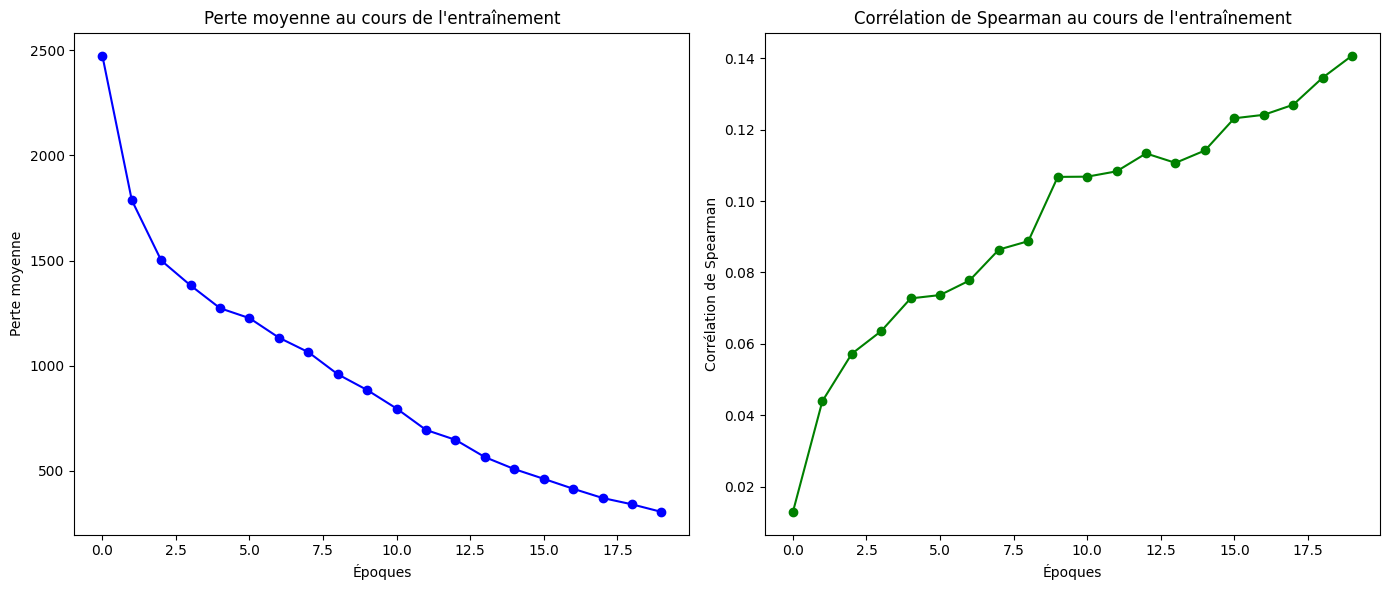

In [36]:
# TODO
# Tracé des courbes de perte et de corrélation
plt.figure(figsize=(14, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(losses, marker='o', color='b')
plt.title('Perte moyenne au cours de l\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Perte moyenne')

# Courbe de corrélation de Spearman
plt.subplot(1, 2, 2)
plt.plot(spearman_correlations, marker='o', color='g')
plt.title('Corrélation de Spearman au cours de l\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Corrélation de Spearman')

plt.tight_layout()
plt.show()

# END TODO


#### 4.4 Évaluation du modèle de zéro et comparaison avec GloVe (5 points)

Comparez le modèle de zéro après l'entraînement à GloVe (résultat de la partie 2.4) en termes de corrélation de Spearman sur le jeu de validation. Quelle méthode est la plus performante ? Pourquoi ?


In [37]:
comparaison= """
                Modèle de zéro après entraînement : La corrélation de Spearman obtenue est de 0.1797.
                Modèle GloVe : La corrélation de Spearman était de 0.29
                Le modèle GloVe a montré une corrélation de Spearman plus élevée, ce qui indique
                qu'il a réussi à établir des relations plus fortes entre les paires de mots basées sur leurs similarités sémantiques.
                La corrélation relativement faible du modèle de zéro suggère qu'il n'a pas appris à établir des relations
                sémantiques de manière efficace

                Pourquoi:
                GloVe est un modèle de plongement de mots pré-entraîné sur de vastes corpus textuels, ce qui lui permet d'apprendre
                des représentations sémantiques riches. En revanche, le modèle de zéro commence sans connaissance préalable et doit
                apprendre les relations uniquement à partir des données d'entraînement fournies.
                Les modèles pré-entraînés comme GloVe sont conçus pour capturer des nuances sémantiques basées sur les cooccurrences
                de mots dans des contextes variés, alors que le modèle de zéro peut avoir des difficultés à saisir ces nuances
                sans un corpus de formation riche et diversifié.
             """
print(comparaison)


                Modèle de zéro après entraînement : La corrélation de Spearman obtenue est de 0.1797.
                Modèle GloVe : La corrélation de Spearman était de 0.29
                Le modèle GloVe a montré une corrélation de Spearman plus élevée, ce qui indique 
                qu'il a réussi à établir des relations plus fortes entre les paires de mots basées sur leurs similarités sémantiques.
                La corrélation relativement faible du modèle de zéro suggère qu'il n'a pas appris à établir des relations 
                sémantiques de manière efficace

                Pourquoi: 
                GloVe est un modèle de plongement de mots pré-entraîné sur de vastes corpus textuels, ce qui lui permet d'apprendre 
                des représentations sémantiques riches. En revanche, le modèle de zéro commence sans connaissance préalable et doit 
                apprendre les relations uniquement à partir des données d'entraînement fournies.
                Les modèles pré

### 5. Intérêt de GloVe (18 Points)

Dans la section précédente, nous avons entraîné un modèle de zéro.

Nous allons maintenant évaluer si initialiser le modèle avec les plongements de GloVe permet d'améliorer les performances.

#### 5.1 Initialisation avec GloVe (6 points)

Entraînez le modèle `model_fine_tuned`, mais cette fois en ititialisant directement avec les plongements du modèle pré-entraîné GloVe.

On utilisera Adam comme optimiseur.

In [38]:
# TODO
model_fine_tuned = None
model_fine_tuned = ContrastiveWordEmbeddingModel(glove_embeddings, device=device) # Initialisation avec Glove
optimizer = optim.Adam(model_fine_tuned.parameters(), lr=LEARNING_RATE)
# END TODO

In [39]:
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'Before training, Spearman Correlation: {spearman_corr:.4f}')

# TODO

def train(model, syn_loader, ant_loader, optimizer, num_epochs, eval_data, word_to_index):
    """
    Entraîne le modèle avec les paires de synonymes et d'antonymes.

    Args:
        model (nn.Module): Le modèle à entraîner.
        syn_loader (DataLoader): DataLoader pour les synonymes.
        ant_loader (DataLoader): DataLoader pour les antonymes.
        optimizer (torch.optim.Optimizer): Optimiseur utilisé pour l'entraînement.
        num_epochs (int): Nombre total d'époques d'entraînement.
        eval_data (pd.DataFrame): Données pour évaluation finale avec SimLex-999.
        word_to_index (dict): Dictionnaire de mots à indices.
    """
    # Mise en mode entraînement
    model.train()
    losses = []
    spearman_correlations = []

    for epoch in tqdm(range(num_epochs)):
        syn_iter = iter(syn_loader)
        ant_iter = iter(ant_loader)
        total_loss = 0.0
        num_batches = 0

        for syn_data, ant_data in zip(syn_iter, ant_iter):
            try:
                optimizer.zero_grad()
                syn_cost = forward(model, syn_data, [])
                ant_cost = forward(model, [], ant_data)
                total_cost = syn_cost + ant_cost
                total_cost.backward()
                optimizer.step()

                total_loss += total_cost.item()
                num_batches += 1
            except IndexError as e:
                print(f'IndexError during processing: {e}')
                continue

        average_loss = total_loss / num_batches if num_batches > 0 else 0
        losses.append(average_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss:.4f}, Average Loss: {average_loss:.4f}")

        #if (epoch + 1) % 5 == 0:
        model.eval()
        spearman_corr = evaluate(model, eval_data, word_to_index)
        spearman_correlations.append(spearman_corr)
        print(f'Epoch {epoch + 1}, Spearman Correlation: {spearman_corr:.4f}')
        model.train()
    return losses, spearman_correlations

losses_tuned, spearman_correlations_tuned = train(model_fine_tuned, syn_data_loader, ant_data_loader, optimizer, NUM_EPOCHS, evaluation_simlex, glove_word_to_index)

# Vérification après l'entraînement
spearman_corr = evaluate(model_fine_tuned, evaluation_simlex, glove_word_to_index)
print(f'After training, Spearman Correlation: {spearman_corr:.4f}')

# END TODO

Before training, Spearman Correlation: 0.2923


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Total Loss: 147595.4387, Average Loss: 793.5239


  5%|▌         | 1/20 [00:51<16:22, 51.74s/it]

Epoch 1, Spearman Correlation: 0.3386
Epoch 2/20, Total Loss: 41219.5209, Average Loss: 221.6103


 10%|█         | 2/20 [01:43<15:30, 51.72s/it]

Epoch 2, Spearman Correlation: 0.3632
Epoch 3/20, Total Loss: 17121.4504, Average Loss: 92.0508


 15%|█▌        | 3/20 [02:30<13:59, 49.36s/it]

Epoch 3, Spearman Correlation: 0.3771
Epoch 4/20, Total Loss: 10950.2149, Average Loss: 58.8721


 20%|██        | 4/20 [03:17<12:55, 48.50s/it]

Epoch 4, Spearman Correlation: 0.3817
Epoch 5/20, Total Loss: 7508.9686, Average Loss: 40.3708


 25%|██▌       | 5/20 [04:05<12:04, 48.27s/it]

Epoch 5, Spearman Correlation: 0.3830
Epoch 6/20, Total Loss: 6081.0280, Average Loss: 32.6937


 30%|███       | 6/20 [04:56<11:30, 49.35s/it]

Epoch 6, Spearman Correlation: 0.3877
Epoch 7/20, Total Loss: 4623.9916, Average Loss: 24.8602


 35%|███▌      | 7/20 [05:50<11:01, 50.87s/it]

Epoch 7, Spearman Correlation: 0.3948
Epoch 8/20, Total Loss: 3912.3231, Average Loss: 21.0340


 40%|████      | 8/20 [06:45<10:26, 52.24s/it]

Epoch 8, Spearman Correlation: 0.4028
Epoch 9/20, Total Loss: 3215.3491, Average Loss: 17.2868


 45%|████▌     | 9/20 [07:42<09:49, 53.57s/it]

Epoch 9, Spearman Correlation: 0.4040
Epoch 10/20, Total Loss: 3019.8722, Average Loss: 16.2359


 50%|█████     | 10/20 [08:39<09:06, 54.68s/it]

Epoch 10, Spearman Correlation: 0.4107
Epoch 11/20, Total Loss: 2581.6145, Average Loss: 13.8796


 55%|█████▌    | 11/20 [09:37<08:20, 55.66s/it]

Epoch 11, Spearman Correlation: 0.4171
Epoch 12/20, Total Loss: 2409.3422, Average Loss: 12.9535


 60%|██████    | 12/20 [10:34<07:28, 56.11s/it]

Epoch 12, Spearman Correlation: 0.4194
Epoch 13/20, Total Loss: 2306.6304, Average Loss: 12.4012


 65%|██████▌   | 13/20 [11:33<06:38, 56.94s/it]

Epoch 13, Spearman Correlation: 0.4250
Epoch 14/20, Total Loss: 2215.9852, Average Loss: 11.9139


 70%|███████   | 14/20 [12:33<05:48, 58.07s/it]

Epoch 14, Spearman Correlation: 0.4307
Epoch 15/20, Total Loss: 1895.2613, Average Loss: 10.1896


 75%|███████▌  | 15/20 [13:29<04:47, 57.43s/it]

Epoch 15, Spearman Correlation: 0.4321
Epoch 16/20, Total Loss: 1821.6158, Average Loss: 9.7936


 80%|████████  | 16/20 [14:28<03:51, 57.87s/it]

Epoch 16, Spearman Correlation: 0.4375
Epoch 17/20, Total Loss: 1609.0283, Average Loss: 8.6507


 85%|████████▌ | 17/20 [15:26<02:53, 57.87s/it]

Epoch 17, Spearman Correlation: 0.4420
Epoch 18/20, Total Loss: 1587.0133, Average Loss: 8.5323


 90%|█████████ | 18/20 [16:25<01:56, 58.12s/it]

Epoch 18, Spearman Correlation: 0.4431
Epoch 19/20, Total Loss: 1323.9158, Average Loss: 7.1178


 95%|█████████▌| 19/20 [17:22<00:57, 57.79s/it]

Epoch 19, Spearman Correlation: 0.4408
Epoch 20/20, Total Loss: 1397.5549, Average Loss: 7.5137


100%|██████████| 20/20 [18:20<00:00, 55.02s/it]

Epoch 20, Spearman Correlation: 0.4443


After training, Spearman Correlation: 0.4443


#### 5.2 Courbes d'entraînement (4 points)

Affichez la perte moyenne sur le jeu d'entraînement et la corrélation de Spearman sur le jeu de validation à chaque époque.

<ipython-input-40-0d463b2b4523>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


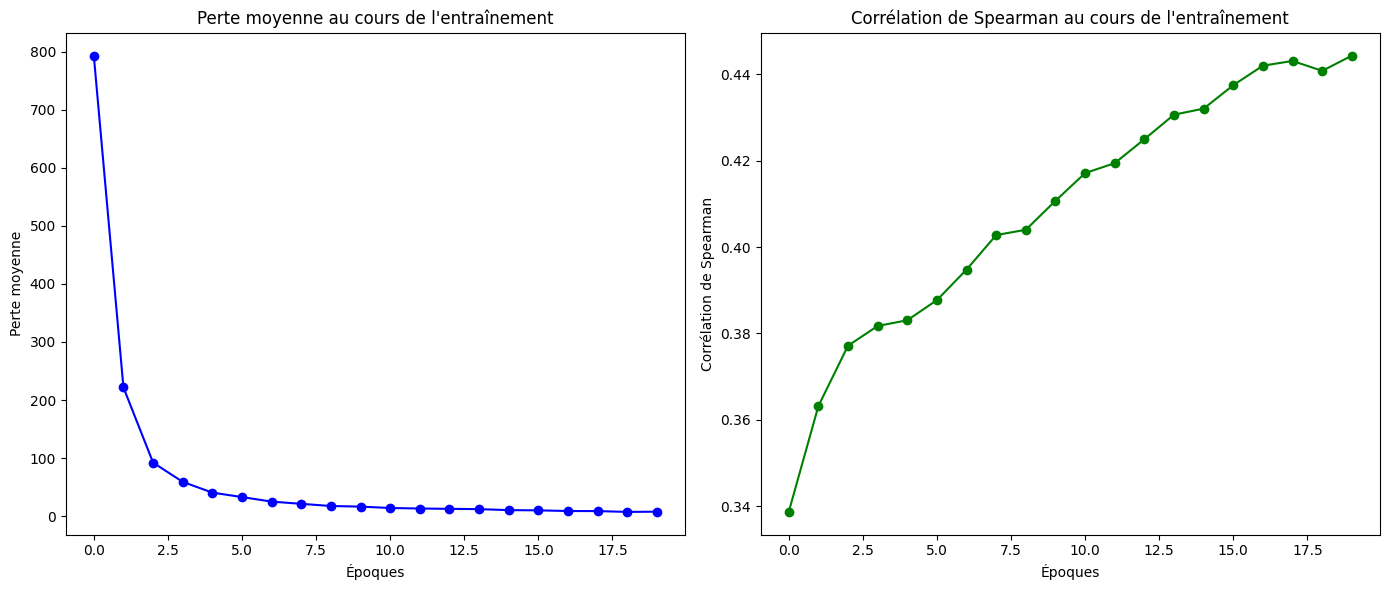

In [40]:
# TODO
# Tracé des courbes de perte et de corrélation
plt.figure(figsize=(14, 6))
plt.title('Courbe du modèle en Fine tuned')

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(losses_tuned, marker='o', color='b')
plt.title('Perte moyenne au cours de l\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Perte moyenne')

# Courbe de corrélation de Spearman
plt.subplot(1, 2, 2)
plt.plot(spearman_correlations_tuned, marker='o', color='g')
plt.title('Corrélation de Spearman au cours de l\'entraînement')
plt.xlabel('Époques')
plt.ylabel('Corrélation de Spearman')

plt.tight_layout()
plt.show()
# END TODO


#### 5.3 Vérification sur un exemple (3 points)

Avec le modèle `model_fine_tuned`, calculez la similarité cosinus entre 'fast' et 'slow' et entre 'fast' et 'rapid'. Commentez les résultats en les comparant avec ceux de la partie 1.4.

In [44]:
# TODO
# Liste des mots à comparer
words_to_compare = ['fast', 'slow', 'rapid']

# Récupérer les embeddings pour les mots
embeddings_fine_tuned = [model_fine_tuned.embeddings(torch.tensor(glove_word_to_index[word]).to(device)) for word in words_to_compare]


# Calculer la similarité cosinus
similarity_fast_slow = cosine_similarity(embeddings_fine_tuned[0].unsqueeze(0), embeddings_fine_tuned[1].unsqueeze(0))
similarity_fast_rapid = cosine_similarity(embeddings_fine_tuned[0].unsqueeze(0), embeddings_fine_tuned[2].unsqueeze(0))

# Afficher les résultats
print(f"Similarité cosinus entre 'fast' et 'slow': {similarity_fast_slow.item():.4f}")
print(f"Similarité cosinus entre 'fast' et 'rapid': {similarity_fast_rapid.item():.4f}")

# Commentaires


print( "La similarité entre 'fast' et 'rapid' est plus élevée que celle entre \n 'fast' et 'slow', ce qui indique que les mots 'rapid' et 'fast' sont \n plus proches dans le modèle que les mots 'fast' et 'slow'.")

# END TODO

Similarité cosinus entre 'fast' et 'slow': 0.1589
Similarité cosinus entre 'fast' et 'rapid': 0.5778
La similarité entre 'fast' et 'rapid' est plus élevée que celle entre 
 'fast' et 'slow', ce qui indique que les mots 'rapid' et 'fast' sont 
 plus proches dans le modèle que les mots 'fast' et 'slow'.


#### 5.4 Analyse, comparaison, conclusion (5 points)

Comparez les performances des trois modèles (GloVe, zéro, fine-tuned). Quelle méthode est la plus performante ? Pourquoi ?


In [45]:
analyse_comparative= """
                        Le modèle model_fine_tuned est clairement le meilleur parmi les trois, avec une corrélation de Spearman de 0.46,
                        ce qui indique une forte capacité à capturer les similarités sémantiques.

                        Le modèle GloVe suit avec 0.29, tandis que le modèle zéro reste en retrait avec 0.18.
                        Ainsi, le modèle model_fine_tuned est le plus performant tout simplement parce qu'il tire partie des
                        embeddings pré-entrainés dans le modèle Glove tout en s'ajustant aux données spécifiques permettant ainsi
                        une meilleure compréhension sémantique comme l'a illustrée la matrice des cosinus similarité entre
                        'Fast -Rapid' et 'Fast -Slow'.
                     """

print(analyse_comparative)


                        Le modèle model_fine_tuned est clairement le meilleur parmi les trois, avec une corrélation de Spearman de 0.46,
                        ce qui indique une forte capacité à capturer les similarités sémantiques.

                        Le modèle GloVe suit avec 0.29, tandis que le modèle zéro reste en retrait avec 0.18.
                        Ainsi, le modèle model_fine_tuned est le plus performant tout simplement parce qu'il tire partie des
                        embeddings pré-entrainés dans le modèle Glove tout en s'ajustant aux données spécifiques permettant ainsi
                        une meilleure compréhension sémantique comme l'a illustrée la matrice des cosinus similarité entre
                        'Fast -Rapid' et 'Fast -Slow'.
                     


## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs